In [2]:
import os
import shutil
import datetime as dt
import csv
import json

PERIOD_LENGTH = 5  # minutes
SOURCE_DIR = os.path.join('.', 'tomtom-voh')
TRAIN_DIR = os.path.join('.', 'is_hot_tomtom_segment_status3')

if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)

def velocity_to_los(velocity):
    if velocity < 15:
        return 'F'
    elif velocity < 20:
        return 'E'
    elif velocity < 25:
        return 'D'
    elif velocity < 30:
        return 'C'
    elif velocity < 35:
        return 'B'
    else:
        return 'A'


def los_to_velocity(los):
    los_to_velocity = {
        'A': 35,
        'B': 30,
        'C': 25,
        'D': 20,
        'E': 15,
        'F': 10,
    }
    return los_to_velocity[los] or 45


def parse_date_and_period(timestamp):
    ts = dt.datetime.fromtimestamp(timestamp)
    date, time, weeekday = ts.date(), ts.time(), ts.weekday()

    h, m, s = time.hour, time.minute, time.second

    hour = f"0{h}" if h < 10 else str(h)
    step = (m * 60 + s) // (PERIOD_LENGTH * 60)
    m = PERIOD_LENGTH * step
    minute = f"0{m}" if m < 10 else str(m)
    period = f"period_{hour}_{minute}"

    return str(date), period, weeekday


def reset():
    shutil.rmtree(TRAIN_DIR)

def get_period_from_timestamp(timestamp):
	timestamp = dt.datetime.fromtimestamp(timestamp)
	hour = timestamp.hour
	minute = timestamp.minute

	if (hour >= 0 and hour <= 5) or (hour >= 9 and hour <= 15) or (hour >= 19 and hour <= 23):
		return "period_{hour}".format(hour=hour)
	if (hour == 24):
		return 'period_0'
	if (minute >= 30):
		return "period_{hour}_30".format(hour=hour)
	return "period_{hour}".format(hour=hour)

def get_seg_weather_data(timestamp, weather_data):
    weather = ""
    temperature = ""
    try:
        time_data = weather_data[str(timestamp)]
        weather = time_data["weather"][0]["main"]
        temperature = time_data["main"]["temp"]
    except:
        pass
    return weather, temperature

def main_is_hot_without_weather_data():
	index = dict()
	# base_data = json.load(open('base_status.json', 'r'))
	output2 = []
	index_2 = 0
	file_path2= os.path.join(TRAIN_DIR, "total_results.csv")
	for f in os.listdir(SOURCE_DIR):
		try:
			timestamp = f.split('.')[0]
			date, period, weekday = parse_date_and_period(int(timestamp))

			filename = period + '.csv'
			folder_path = os.path.join(TRAIN_DIR, date)
			file_path = os.path.join(TRAIN_DIR, date, filename)

			# Prepare
			if not os.path.exists(folder_path):
				os.makedirs(folder_path)

			header = ['id', 'period', 'segment_id',
					'date', 'weekday', 'tomtom_velocity', 'base_LOS', 'isHot', 'weather', 'temperature']
			if not os.path.exists(file_path):
				index[f"{date}/{period}"] = 0
				with open(file_path, newline='', mode='w') as new_file:
					writer = csv.writer(new_file)
					writer.writerow(header)

			# Read data
			output = []
			with open(os.path.join(SOURCE_DIR, f), 'r') as in_file:
				data = json.load(in_file)
				for k, v in data.items():
					isHot = True
					if v['source'] != 'tom-tom' or not isHot: continue
					base_LOS = velocity_to_los(v['velocity'])

					output.append([index[f"{date}/{period}"], period, k, date, 
						weekday, v['velocity'], base_LOS, isHot, "few clouds", 27])
					output2.append([index_2, period, k, date, 
						weekday, v['velocity'], base_LOS, isHot, "few clouds", 27])
					index_2 += 1
					print(f, output[-1])
					index[f"{date}/{period}"] += 1
			# Write transformed data
			with open(file_path, newline='', mode='a+') as out_file:
				writer = csv.writer(out_file)
				writer.writerows(output)
		except:
			continue
	header = ['id', 'period', 'segment_id',
					'date', 'weekday', 'tomtom_velocity', 'base_LOS', 'isHot', 'weather', 'temperature']
	with open(file_path2, newline='', mode='a+') as out_file2:
		writer = csv.writer(out_file2)
		writer.writerow(header)
		writer.writerows(output2)
		


In [7]:
a = os.listdir(SOURCE_DIR)
print(a)

['2023-05-04', '2023-05-03', '2023-05-02', '2023-05-05', '2023-04-28', '2023-04-21', '2023-04-26', '2023-04-19', '2023-04-27', '2023-04-20', '2023-04-29', '2023-05-10', '2023-05-07', '2023-05-09', '2023-05-08', '2023-05-06', '2023-05-01', '2023-04-30', '2023-04-25', '2023-04-22', '2023-04-23', '2023-04-24']


In [8]:
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)

# Tạo file csv từ file json và lưu theo từng ngày

In [6]:
# reset()
main_is_hot_without_weather_data()

# 2. Xử lý dữ liệu để tạo ra trường dữ liệu Duration

In [117]:
import pandas as pd
# result_df = pd.read_csv(os.path.join(TRAIN_DIR, a[0], b[0]))
# print(result_df.shape)
TRAIN_DIR2 = os.path.join('.', 'result_df2')

if not os.path.exists(TRAIN_DIR2):
    os.makedirs(TRAIN_DIR2)
# shutil.rmtree(TRAIN_DIR2)

## 2.1 Function để lấy tạo giá trị duration cho từng phút

In [118]:
def get_duration(x, df_data):
    temp_data = df_data.loc[(df_data.segment_id == x.segment_id)].sort_values(by=['period'], ascending = False).iloc[-1]
    if len(temp_data) > 0:
        if temp_data.base_LOS == x.base_LOS:
            result_duration = int(temp_data.duration) + 1
        else:
#             print("---------",temp_data.segment_id)
            result_duration = 1
    else:
#         print(temp_data.segment_id)
        result_duration = 1
    return result_duration

## 2.2 Function tổng hợp dữ liệu cho từng ngày trên tất cả đoạn đường

In [119]:
def get_result_df(pre_path_df, b):
    result_df = pd.read_csv(os.path.join(pre_path_df, b[0]))
    for index, i in enumerate(b):
        temp_df = pd.read_csv(os.path.join(pre_path_df, i))
        if index == 0:
            result_df['duration'] = [1]*temp_df.shape[0]
        else:
            duration_list = temp_df.apply(get_duration, axis=1, args=(result_df,))
            temp_df['duration'] = duration_list
            result_df = pd.concat([result_df, temp_df])
    result_df.drop(["id","date"], axis=1, inplace=True)

    return result_df


        
    
    
    

## 2.3 Tạo ra file chứa toàn bộ dữ liệu

In [120]:
a = list(os.listdir(TRAIN_DIR))
a = sorted(a, reverse=False)
total_df = pd.DataFrame()
for index_a, item_a in enumerate(a):
    pre_path_df = os.path.join(TRAIN_DIR, item_a)
    b = os.listdir(os.path.join(TRAIN_DIR,item_a))
    b = sorted(b, reverse=True)
    print("---------item_a--------", item_a)
    result_df = get_result_df(pre_path_df, b)
    if index_a == 0:
        total_df = result_df
    else:
        total_df = pd.concat([total_df, result_df])
    df_name = item_a + ' result_df' + '.csv'
    result_df.to_csv(os.path.join(TRAIN_DIR2, df_name))
    
total_df.to_csv(os.path.join(TRAIN_DIR2, "total_df.csv"))

---------item_a-------- 2022-03-20
---------item_a-------- 2022-03-21
---------item_a-------- 2022-03-22
---------item_a-------- 2022-03-23
---------item_a-------- 2022-03-24
---------item_a-------- 2022-03-25
---------item_a-------- 2022-03-26
---------item_a-------- 2022-03-27
---------item_a-------- 2022-03-28
---------item_a-------- 2022-03-29
---------item_a-------- 2022-03-30
---------item_a-------- 2022-03-31
---------item_a-------- 2022-04-01
---------item_a-------- 2022-04-02
---------item_a-------- 2022-04-03
---------item_a-------- 2022-04-04
---------item_a-------- 2022-04-05
---------item_a-------- 2022-04-06
---------item_a-------- 2022-04-07
---------item_a-------- 2022-04-08
---------item_a-------- 2022-04-09
---------item_a-------- 2022-04-10
---------item_a-------- 2022-04-11
---------item_a-------- 2022-04-12
---------item_a-------- 2022-04-16
---------item_a-------- 2022-04-17
---------item_a-------- 2022-04-18
---------item_a-------- 2022-04-19
---------item_a-----

# 3. Bài toán Data mining

## 3.1 Tiền xử lý dữ liệu

In [156]:
total_df = pd.read_csv("./result_df2/total_df.csv")

In [157]:
total_df.drop(["Unnamed: 0.1","Unnamed: 0"], axis=1, inplace=True)

In [161]:
total_df.columns

Index(['period', 'segment_id', 'weekday', 'tomtom_velocity', 'base_LOS',
       'isHot', 'weather', 'temperature', 'duration'],
      dtype='object')

In [158]:
total_df.head(5)

,period,segment_id,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,duration
0,period_23_10,21516,6,49,A,True,few clouds,27,1
1,period_23_10,2862,6,49,A,True,few clouds,27,1
2,period_23_10,2863,6,49,A,True,few clouds,27,1
3,period_23_10,2864,6,49,A,True,few clouds,27,1
4,period_23_10,2865,6,49,A,True,few clouds,27,1


In [162]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10600470 entries, 0 to 10600469
Data columns (total 9 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   period           object
 1   segment_id       int64 
 2   weekday          int64 
 3   tomtom_velocity  int64 
 4   base_LOS         object
 5   isHot            bool  
 6   weather          object
 7   temperature      int64 
 8   duration         int64 
dtypes: bool(1), int64(5), object(3)
memory usage: 657.1+ MB


In [163]:
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

In [164]:
label_encoder = LabelEncoder()
total_df['base_LOS']= label_encoder.fit_transform(total_df['base_LOS'])
total_df['isHot']= label_encoder.fit_transform(total_df['isHot'])
total_df['weather']= label_encoder.fit_transform(total_df['weather'])



In [165]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10600470 entries, 0 to 10600469
Data columns (total 9 columns):
 #   Column           Dtype
---  ------           -----
 0   period           int64
 1   segment_id       int64
 2   weekday          int64
 3   tomtom_velocity  int64
 4   base_LOS         int64
 5   isHot            int64
 6   weather          int64
 7   temperature      int64
 8   duration         int64
dtypes: int64(9)
memory usage: 727.9 MB


In [166]:
total_df.head(5)

,period,segment_id,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,duration
0,278,21516,6,49,0,0,0,27,1
1,278,2862,6,49,0,0,0,27,1
2,278,2863,6,49,0,0,0,27,1
3,278,2864,6,49,0,0,0,27,1
4,278,2865,6,49,0,0,0,27,1


In [168]:
total_df['base_LOS'].unique()

array([0, 5, 1, 3, 2, 4])

In [189]:
from sklearn.cluster import KMeans

In [191]:
total_df.describe()

,period,segment_id,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,duration
count,1.060047e+07,1.060047e+07,1.060047e+07,1.060047e+07,1.060047e+07,10600470.0,10600470.0,10600470.0,1.060047e+07
mean,1.440000e+02,4.390613e+04,2.925728e+00,4.029083e+01,4.706437e-01,0.0,0.0,27.0,5.247215e+01
std,8.297846e+01,2.039736e+04,2.061850e+00,9.158991e+00,1.092498e+00,0.0,0.0,0.0,6.423731e+01
min,0.000000e+00,2.862000e+03,0.000000e+00,2.000000e+00,0.000000e+00,0.0,0.0,27.0,1.000000e+00
25%,7.200000e+01,2.150500e+04,1.000000e+00,3.500000e+01,0.000000e+00,0.0,0.0,27.0,6.000000e+00
50%,1.440000e+02,4.192650e+04,3.000000e+00,4.300000e+01,0.000000e+00,0.0,0.0,27.0,2.800000e+01
75%,2.160000e+02,6.346300e+04,5.000000e+00,4.900000e+01,0.000000e+00,0.0,0.0,27.0,7.300000e+01
max,2.870000e+02,8.173800e+04,6.000000e+00,5.000000e+01,5.000000e+00,0.0,0.0,27.0,2.760000e+02


In [201]:
end_df = total_df.drop(columns=["isHot", "weather", "temperature", "base_LOS"], inplace=False)
end_df.head(5)

,period,segment_id,weekday,tomtom_velocity,base_LOS,duration
0,278,21516,6,49,0,1
1,278,2862,6,49,0,1
2,278,2863,6,49,0,1
3,278,2864,6,49,0,1
4,278,2865,6,49,0,1


In [195]:
total_df['weekday'].unique()

array([6, 0, 1, 2, 3, 4, 5])

In [199]:
period_df = total_df.loc[(total_df.period == 0)&(total_df.weekday ==1)]
period_df.head(5)

,period,segment_id,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,duration
432540,0,21516,1,49,0,0,0,27,100
432541,0,2862,1,49,0,0,0,27,100
432542,0,2863,1,49,0,0,0,27,100
432543,0,2864,1,49,0,0,0,27,100
432544,0,2865,1,49,0,0,0,27,100


In [ ]:
for period_item in total_df['period'].unique():
    period_df = total_df.loc[(total_df.period == period_item)&(total_df.weather ==)]
    

In [219]:
from sklearn.preprocessing import StandardScaler

In [225]:
period_df_time = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS"], axis=1)

In [242]:
len(period_df_time)

4860

In [227]:
scaled_df = StandardScaler().fit_transform(period_df_time)

In [228]:
print(scaled_df[:5])

[[ 0.46173895 -0.22763262  0.08530135]
 [ 0.46173895 -0.22763262  0.08530135]
 [ 0.46173895 -0.22763262  0.08530135]
 [ 0.46173895 -0.22763262  0.08530135]
 [ 0.46173895 -0.22763262  0.08530135]]


In [229]:
losses = []
K = 10
for i in range(1, K):
  # 1.  Huấn luyện với số cụm = i
  kmeans_i = KMeans(n_clusters=i, random_state=0)
  kmeans_i.fit(scaled_df)
  # 2. Tính _hàm biến dạng_
  # 2.1. Khoảng cách tới toàn bộ centroids
  d2centroids = cdist(scaled_df, kmeans_i.cluster_centers_, 'euclidean') # shape (n, k)
  # 2.2. Khoảng cách tới centroid gần nhất
  min_distance = np.min(d2centroids, axis=1) # shape (n)
  loss = np.sum(min_distance)
  losses.append(loss)

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/pytho

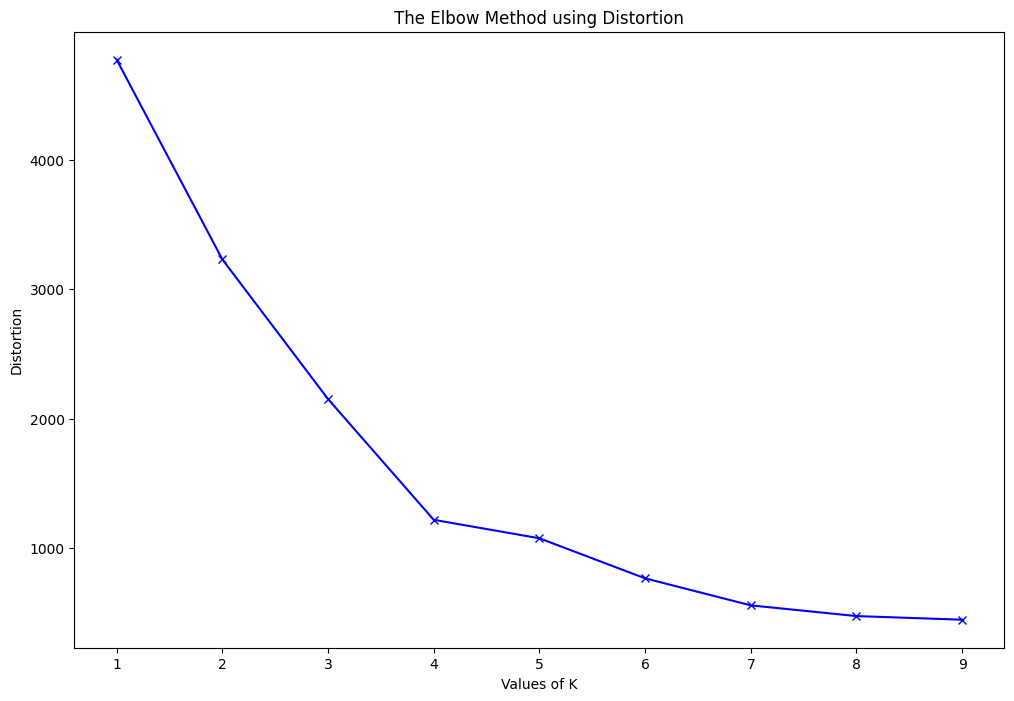

In [230]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, K), losses, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [238]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(scaled_df)

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=0)

In [239]:
import seaborn as sns

In [240]:
print('kmeans labels of 5 observation: ', kmeans.labels_[:5])

kmeans labels of 5 observation:  [1 1 1 1 1]


In [241]:
np.unique(kmeans.labels_[:5])

array([1], dtype=int32)

In [250]:
X = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS"], axis=1)
X.head(5)



,tomtom_velocity,duration
432540,49,100
432541,49,100
432542,49,100
432543,49,100
432544,49,100


In [251]:
X = StandardScaler().fit_transform(X)

Text(0.5, 1.0, 'Distribution of Shopping Dataset')

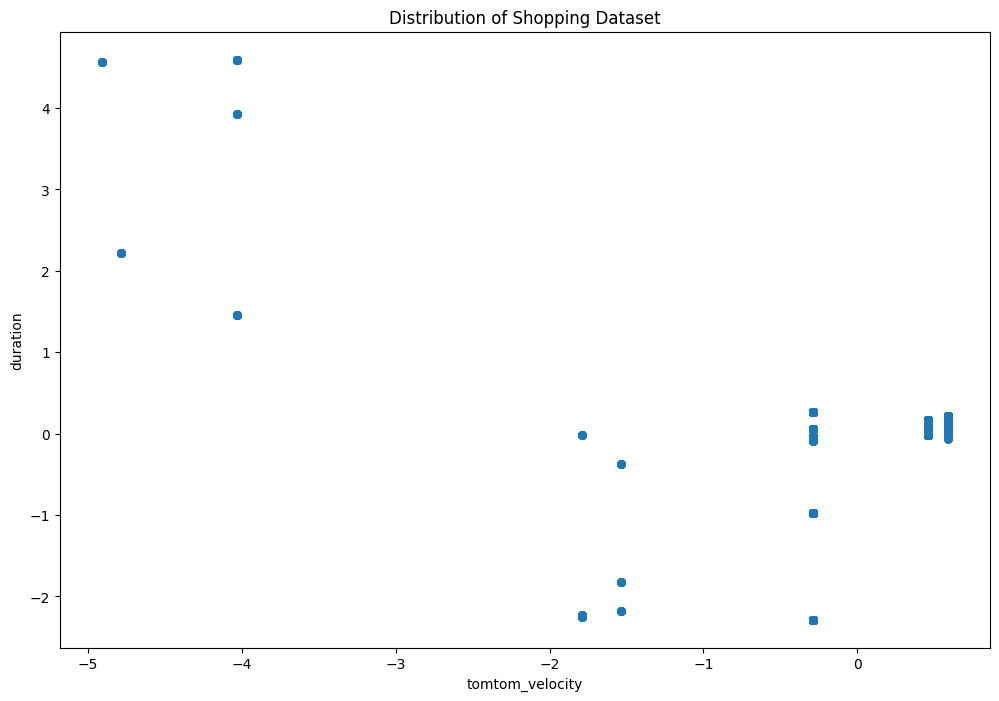

In [255]:
# Biểu đồ hoá các điểm dữ liệu trên đồ thị scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], lw=0, s=40)
plt.xlabel('tomtom_velocity')
plt.ylabel('duration')
plt.title('Distribution of Shopping Dataset')

In [256]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

In [257]:
print('kmeans labels of 5 observation: ', kmeans.labels_[:5])

kmeans labels of 5 observation:  [1 1 1 1 1]


In [260]:
y_clusters = kmeans.fit_predict(X)

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [263]:
np.unique(y_clusters, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([ 355, 2916,  192, 1397]))

<Axes: ylabel='count'>

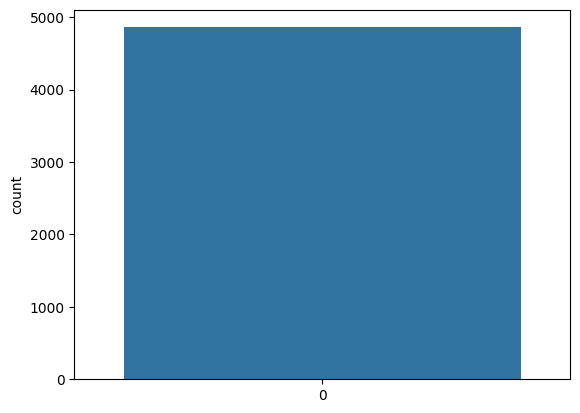

In [261]:
sns.countplot(y_clusters)

In [272]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.patheffects as PathEffects

Text(0, 0.5, 'dissimilarity metric cluster')

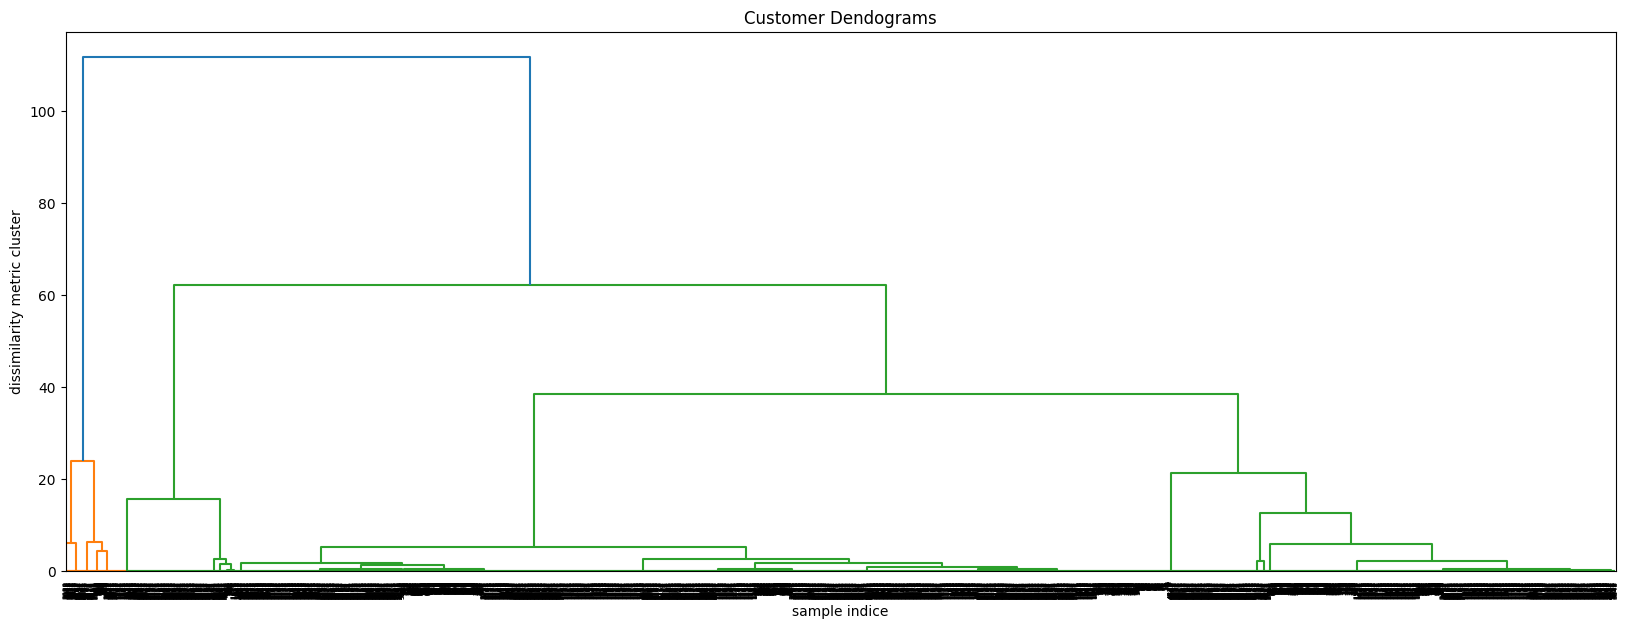

In [267]:
plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(200, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

In [276]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = cluster.fit_predict(X)

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


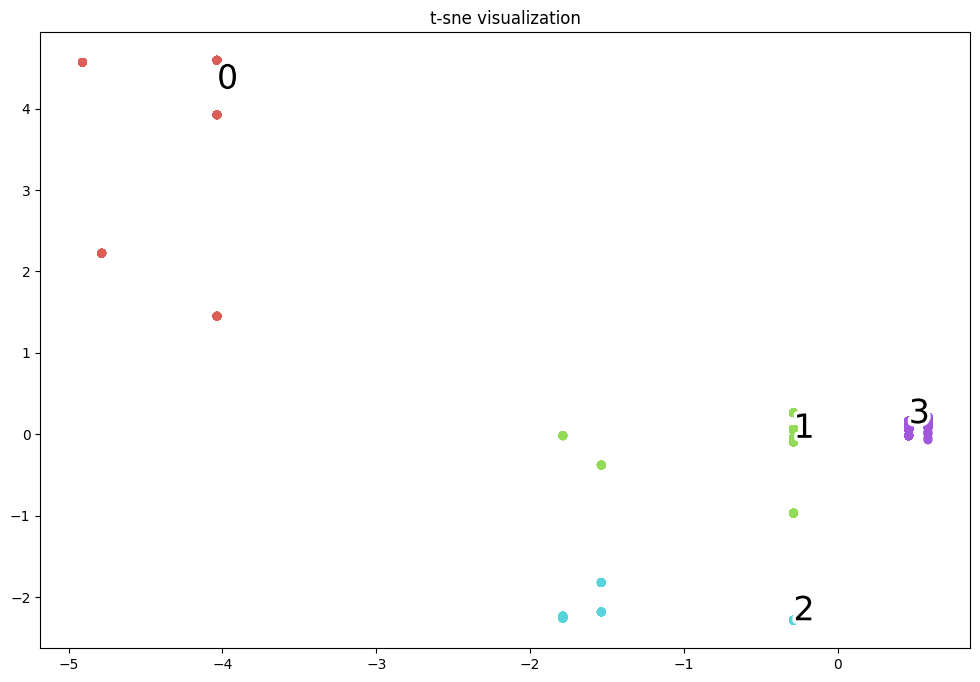

In [277]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int16)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

_plot_kmean_scatter(X, labels)